### Index

[1. Presentation of the challenge](#1) <br>
- [1.1 - The RavenPack Data Science Challenge](#1.1) <br>
- [1.2 - Overview of the approach](#1.2)<br><br>

[2. Collect & transform data](#2) <br>
- [2.1 - Connection à SQL Server](#2.1) <br>
- [2.2 - Mise au format des données](#2.2)<br>
- [](#2.3)<br>
- [](#2.4)<br>
- [](#2.5)<br>

[3. Descriptive analysis / Statistical inferences](#3) <br>
- [](#3.1)<br>
- [](#3.2)<br>
- [](#3.3)<br>
- [](#3.4)<br>

[4. Preprocess the data](#4) <br>
- [4.1 - Clustering](#4.1)<br>
- [4.2 - Création de la target (y)](#4.2)<br>
- [4.3 - Valeurs aberrantes](#4.3)<br>
- [4.4 - One-hot-encoding](#4.4)<br><br>

[5. Create features](#5) <br>
- [5.1 - Dataset du modèle 1](#5.1)<br>
- [](#5.2)<br>
- [](#5.3)<br>
- [](#5.4)<br>

[6. Select a ML algo](#6) <br>
- [6.1 - Dataset du modèle 1](#6.1)<br>
- [](#6.2)<br>
- [](#6.3)<br>
- [](#6.4)<br>

[7. Backtest on unseen data](#7) <br>
- [7.1 - Dataset du modèle 1](#7.1)<br>
- [](#7.2)<br>
- [](#7.3)<br>
- [](#7.4)<br>

In [2]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from IPython.core.display import display, HTML
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tslearn.utils import to_time_series_dataset

In [4]:
%matplotlib inline

import sys, os
import warnings
from time import time
from itertools import product
import joblib
from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
# needed for HistGradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.inspection import partial_dependence, plot_partial_dependence
from sklearn.metrics import roc_auc_score

In [17]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import statistics
from scipy.stats import spearmanr
from sklearn.neighbors import (KNeighborsClassifier, 
                               KNeighborsRegressor)
from sklearn.model_selection import (cross_val_score, 
                                     cross_val_predict, 
                                     GridSearchCV)
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler, scale
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
import statistics
# from yellowbrick.model_selection import ValidationCurve, LearningCurve


from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
# from IPython.display import display
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import VotingClassifier


from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
from statistics import *
from statsmodels.tsa.stattools import adfuller
from numpy import log

In [5]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.max_columns = None

In [6]:
display(HTML("<style> *{margin:0; padding:0;} html, body, \
             .container{margin:2;!important padding:0;!important} \
             .container { width:100% !important;}</style>"))

In [345]:
df = pd.read_csv('../SampleDataSet.csv')
df['DATE'] = pd.to_datetime(df['DATE'])
descr = df.describe()
df = df.groupby(['RP_ENTITY_ID', 'DATE'], as_index=False).first()
###col with 100% NA
cols_to_drop = descr.columns[descr.loc['count',:]==0]
###delete these cols
df = df.loc[:, ~df.columns.isin(cols_to_drop)]
# q = 0.9995
# df = df.loc[ (df['T0_RETURN']<df['T0_RETURN'].quantile(q)) 
#             & (df['T0_RETURN']>df['T0_RETURN'].quantile(1-q)) 
#             & (df['T1_RETURN']<df['T1_RETURN'].quantile(q)) 
#             & (df['T1_RETURN']>df['T1_RETURN'].quantile(1-q)) ]



nb_date_ceil = 10000
nb_date_floor = 756 #3y track record
list_asset = df.RP_ENTITY_ID.value_counts().loc[(df.RP_ENTITY_ID.value_counts()<nb_date_ceil)&(df.RP_ENTITY_ID.value_counts()>nb_date_floor)].index
list_asset = list(list_asset)

df_track_perf = df.loc[df['RP_ENTITY_ID'].isin(list_asset),:]
# df_track_perf.describe()

df_track_perf['T0_RETURN_log'] = np.log(1+df_track_perf.loc[:,'T0_RETURN'].copy()) ##use log return
df_track_perf['T1_RETURN_log'] = np.log(1+df_track_perf.loc[:,'T1_RETURN'].copy()) ##use log return
cols_to_drop = ['T0_RETURN', 'T1_RETURN']
df_track_perf = df_track_perf.loc[:, ~df_track_perf.columns.isin(cols_to_drop)]

df_train_valid_inter = df_track_perf.iloc[ :int(round(len(df_track_perf)*0.85,0)) , :]
# ret = 0.0
# perf_range = (df_train_valid_inter['T1_RETURN_log']>=ret) | (df_train_valid_inter['T1_RETURN_log']<-ret)
# df_train_valid = df_train_valid_inter.loc[ perf_range ] ################# CHANGER LE SPLIT TRAIN VALID !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# df_test = df_track_perf.iloc[int(round(len(df_track_perf)*0.85+30,0)): , :] ### EMBARGO

In [317]:
df_train_valid_inter

,RP_ENTITY_ID,DATE,GLOBAL_ALL,GLOBAL_HEAD,GLOBAL_BODY,GLOBAL_ALL_SG90,GLOBAL_HEAD_SG90,GLOBAL_BODY_SG90,GLOBAL_ALL_SG365,GLOBAL_HEAD_SG365,GLOBAL_BODY_SG365,GROUP_A_ALL,GROUP_A_HEAD,GROUP_A_BODY,GROUP_A_ALL_SG90,GROUP_A_HEAD_SG90,GROUP_A_BODY_SG90,GROUP_A_ALL_SG365,GROUP_A_HEAD_SG365,GROUP_A_BODY_SG365,GROUP_E_ALL,GROUP_E_HEAD,GROUP_E_BODY,GROUP_E_ALL_SG90,GROUP_E_HEAD_SG90,GROUP_E_BODY_SG90,GROUP_E_ALL_SG365,GROUP_E_HEAD_SG365,GROUP_E_BODY_SG365,GROUP_AM_BODY,T0_RETURN_log,T1_RETURN_log
0,00067A,2005-01-05,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,nan,nan,0.000,nan,nan,nan,nan,nan,nan,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.029,-0.006
1,00067A,2005-01-06,0.000,nan,0.000,0.000,nan,0.000,0.000,nan,0.000,nan,nan,0.000,nan,nan,nan,nan,nan,nan,0.000,nan,0.000,0.000,nan,0.000,0.000,nan,0.000,0.000,-0.006,-0.005
2,00067A,2005-01-20,0.000,nan,0.000,0.000,nan,0.000,0.000,nan,0.000,nan,nan,0.000,nan,nan,nan,nan,nan,nan,0.000,nan,0.000,0.000,nan,0.000,0.000,nan,0.000,0.000,-0.010,0.019
3,00067A,2005-01-21,0.001,0.010,0.000,0.001,0.010,0.000,0.001,0.010,0.000,0.010,0.010,0.000,0.010,0.010,nan,0.010,0.010,nan,0.000,nan,0.000,0.000,nan,0.000,0.000,nan,0.000,0.000,0.019,0.002
4,00067A,2005-01-26,0.000,nan,0.000,0.000,nan,0.000,0.000,nan,0.000,nan,nan,0.000,nan,nan,nan,nan,nan,nan,0.000,nan,0.000,0.000,nan,0.000,0.000,nan,0.000,0.000,-0.001,0.012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601973,D8F347,2013-04-16,0.000,nan,0.000,nan,nan,nan,nan,nan,nan,nan,nan,0.000,nan,nan,nan,nan,nan,nan,0.000,nan,0.000,nan,nan,nan,nan,nan,nan,0.000,0.013,-0.003
601974,D8F347,2013-04-17,0.000,nan,0.000,nan,nan,nan,nan,nan,nan,nan,nan,0.000,nan,nan,nan,nan,nan,nan,0.000,nan,0.000,nan,nan,nan,nan,nan,nan,0.000,-0.003,0.045
601975,D8F347,2013-04-18,0.495,0.564,0.382,0.598,0.636,0.200,0.607,0.636,0.000,nan,nan,0.382,nan,nan,nan,nan,nan,nan,0.495,0.564,0.382,0.598,0.636,0.200,0.607,0.636,0.000,0.382,0.045,0.014
601976,D8F347,2013-04-19,0.503,0.424,0.534,nan,nan,nan,nan,nan,nan,0.340,0.340,0.534,nan,nan,nan,nan,nan,nan,0.524,0.480,0.534,nan,nan,nan,nan,nan,nan,0.534,0.014,0.007


In [148]:
df_test

,DATE,RP_ENTITY_ID,GLOBAL_ALL,GLOBAL_HEAD,GLOBAL_BODY,GLOBAL_ALL_SG90,GLOBAL_HEAD_SG90,GLOBAL_BODY_SG90,GLOBAL_ALL_SG365,GLOBAL_HEAD_SG365,GLOBAL_BODY_SG365,GROUP_A_ALL,GROUP_A_HEAD,GROUP_A_BODY,GROUP_A_ALL_SG90,GROUP_A_HEAD_SG90,GROUP_A_BODY_SG90,GROUP_A_ALL_SG365,GROUP_A_HEAD_SG365,GROUP_A_BODY_SG365,GROUP_E_ALL,GROUP_E_HEAD,GROUP_E_BODY,GROUP_E_ALL_SG90,GROUP_E_HEAD_SG90,GROUP_E_BODY_SG90,GROUP_E_ALL_SG365,GROUP_E_HEAD_SG365,GROUP_E_BODY_SG365,GROUP_AM_BODY,T0_RETURN_log,T1_RETURN_log
588225,2015-11-02,13C3E0,0.630,nan,0.630,nan,nan,nan,nan,nan,nan,nan,nan,0.630,nan,nan,nan,nan,nan,nan,nan,nan,0.630,nan,nan,nan,nan,nan,nan,0.630,-0.010,-0.000
588228,2015-11-02,164D72,0.523,0.500,0.570,0.570,nan,0.570,0.570,nan,0.570,nan,nan,0.570,nan,nan,nan,nan,nan,nan,nan,nan,0.570,nan,nan,nan,nan,nan,nan,0.570,0.001,0.023
588229,2015-11-02,168A5D,0.193,nan,0.193,0.000,nan,0.000,0.000,nan,0.000,nan,nan,0.193,nan,nan,nan,nan,nan,nan,0.000,nan,0.193,0.000,nan,0.000,0.000,nan,0.000,0.193,0.002,-0.006
588231,2015-11-02,17EDA5,0.496,nan,0.496,0.585,nan,0.585,0.585,nan,0.585,nan,nan,0.496,nan,nan,nan,nan,nan,nan,nan,nan,0.496,nan,nan,nan,nan,nan,nan,0.496,-0.008,0.003
588232,2015-11-02,1921DD,0.503,0.509,0.496,0.435,0.509,0.287,0.397,0.500,0.190,nan,nan,0.496,nan,nan,nan,nan,nan,nan,0.000,nan,0.496,0.000,nan,0.000,0.000,nan,0.000,0.496,0.001,0.004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
712515,2017-02-16,F6E248,0.506,nan,0.506,0.393,nan,0.393,0.285,nan,0.285,nan,nan,0.506,nan,nan,nan,nan,nan,nan,0.000,nan,0.506,0.000,nan,0.000,0.000,nan,0.000,0.506,0.009,-0.008
712522,2017-02-16,FACF19,0.471,0.480,0.468,0.387,nan,0.387,0.387,nan,0.387,0.540,nan,0.468,0.540,nan,0.540,0.540,nan,0.540,0.000,nan,0.468,0.000,nan,0.000,0.000,nan,0.000,0.468,0.018,0.001
712524,2017-02-16,FC1B7B,0.407,nan,0.407,0.305,nan,0.305,0.305,nan,0.305,nan,nan,0.407,nan,nan,nan,nan,nan,nan,0.407,nan,0.407,0.305,nan,0.305,0.305,nan,0.305,0.407,0.010,-0.002
712531,2017-02-16,FEC475,-0.039,0.000,-0.044,0.203,0.000,0.305,0.203,0.000,0.305,-0.580,nan,-0.044,nan,nan,nan,nan,nan,nan,0.302,0.000,-0.044,0.203,0.000,0.305,0.203,0.000,0.305,-0.044,0.005,-0.004


___
# <a id =4> </a> **4. Preprocess the data**
___

Strategy: We implemented a trading strategy in simulation as follows: On the first trading day of each week, we compute a forecast for each member of the S&P 500. We assess each decile (groups of 50) of stocks ranked from highest forecast to lowest, as follows: We enter an equally-weighted long position in each group of 50 stocks. Positions are held one week, and then rebalanced.

Reversion
Momentum
Seasonality
Lead-lag
Learning...


Events: 
=> entity detection: companies, people, products, commo, fx, orga...
=> envent detection: 5 broader topics: business, economic, societal, political, environmental
- Event relevance 
- Novel event (first time you see a particuliar event since a certain time)
- Event buzz (abnormal news volume)
- Sentiment scoring

## <a id =4.1> </a>4.1 Clustering

In [ ]:
# Native libraries
import os
import math
# Essential Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
# Algorithms
# from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

n order to cluster our series with k-means, the essential thing to do is, as we do it with som, removing our time indices from our time series, and instead of measured values of each date, we should accept them as different features and dimensions of a single data point. Another important thing to do is, selecting the distance metric. In the k-means algorithm, people usually use the euclidean distance but as we've seen in DBA, it is not effective in our case. So, we will be using Dynamic Time Warping (DTW) instead of euclidean distance and you can see why we are doing this in the following images.

Dynamic Time Warping Distance Metric for Time Series But first, why is the common Euclidean distance metric is unsuitable for time series? In short, it is invariant to time shifts, ignoring the time dimension of the data. If two time series are highly correlated, but one is shifted by even one time step, Euclidean distance would erroneously measure them as further apart. Instead, it is better to use dynamic time warping (DTW) to compare series. DTW is a technique to measure similarity between two temporal sequences that do not align exactly in time, speed, or length.

In [13]:
df_track_perf

,DATE,RP_ENTITY_ID,GLOBAL_ALL,GLOBAL_HEAD,GLOBAL_BODY,GLOBAL_ALL_SG90,GLOBAL_HEAD_SG90,GLOBAL_BODY_SG90,GLOBAL_ALL_SG365,GLOBAL_HEAD_SG365,GLOBAL_BODY_SG365,GROUP_A_ALL,GROUP_A_HEAD,GROUP_A_BODY,GROUP_A_ALL_SG90,GROUP_A_HEAD_SG90,GROUP_A_BODY_SG90,GROUP_A_ALL_SG365,GROUP_A_HEAD_SG365,GROUP_A_BODY_SG365,GROUP_E_ALL,GROUP_E_HEAD,GROUP_E_BODY,GROUP_E_ALL_SG90,GROUP_E_HEAD_SG90,GROUP_E_BODY_SG90,GROUP_E_ALL_SG365,GROUP_E_HEAD_SG365,GROUP_E_BODY_SG365,GROUP_AM_BODY,T0_RETURN_log,T1_RETURN_log
0,2005-01-03,0157B1,0.610,nan,0.610,0.610,nan,0.610,0.610,nan,0.610,nan,nan,0.610,nan,nan,nan,nan,nan,nan,0.610,nan,0.610,0.610,nan,0.610,0.610,nan,0.610,0.610,0.018,-0.038
3,2005-01-03,0BC29E,0.550,nan,0.550,0.550,nan,0.550,0.550,nan,0.550,nan,nan,0.550,nan,nan,nan,nan,nan,nan,nan,nan,0.550,nan,nan,nan,nan,nan,nan,0.550,0.019,0.019
7,2005-01-03,1921DD,0.532,0.532,nan,0.500,0.500,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.016,0.004
8,2005-01-03,1A3E1B,0.000,0.000,nan,0.000,0.000,nan,0.000,0.000,nan,0.000,0.000,nan,0.000,0.000,nan,0.000,0.000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.006,0.017
11,2005-01-03,248F44,0.400,nan,0.400,nan,nan,nan,nan,nan,nan,nan,nan,0.400,nan,nan,nan,nan,nan,nan,0.400,nan,0.400,nan,nan,nan,nan,nan,nan,0.400,0.019,0.006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
712515,2017-02-16,F6E248,0.506,nan,0.506,0.393,nan,0.393,0.285,nan,0.285,nan,nan,0.506,nan,nan,nan,nan,nan,nan,0.000,nan,0.506,0.000,nan,0.000,0.000,nan,0.000,0.506,0.009,-0.008
712522,2017-02-16,FACF19,0.471,0.480,0.468,0.387,nan,0.387,0.387,nan,0.387,0.540,nan,0.468,0.540,nan,0.540,0.540,nan,0.540,0.000,nan,0.468,0.000,nan,0.000,0.000,nan,0.000,0.468,0.018,0.001
712524,2017-02-16,FC1B7B,0.407,nan,0.407,0.305,nan,0.305,0.305,nan,0.305,nan,nan,0.407,nan,nan,nan,nan,nan,nan,0.407,nan,0.407,0.305,nan,0.305,0.305,nan,0.305,0.407,0.010,-0.002
712531,2017-02-16,FEC475,-0.039,0.000,-0.044,0.203,0.000,0.305,0.203,0.000,0.305,-0.580,nan,-0.044,nan,nan,nan,nan,nan,nan,0.302,0.000,-0.044,0.203,0.000,0.305,0.203,0.000,0.305,-0.044,0.005,-0.004


In [8]:
time_series_0 = df_track_perf.loc[:,['DATE', 'RP_ENTITY_ID', 'T0_RETURN_log']].pivot_table(index='DATE',columns='RP_ENTITY_ID',values='T0_RETURN_log')
time_series_0

RP_ENTITY_ID,00067A,013528,0157B1,034B61,03B8CF,047E26,048590,055018,061366,061856,09DE1F,0A9D0A,0BC29E,0BF4BA,0F0440,0F7B72,12A3A3,12DE76,12E454,131443,13C3E0,143C52,14BA06,164D72,168A5D,16B183,17EDA5,1921DD,1A3E1B,1BC12C,1D1B07,1D3EEA,1FAF22,205AD5,228D42,248F44,24CB56,25102A,251988,2667B6,267718,28DEFA,2B49F4,2B7A40,2BA977,2CB4C9,2D643C,2E61CC,319E7D,3279AD,33AD83,3461CF,353DBB,3587B4,385DD4,385DD5,39692D,39BFF6,3B23F5,3C7F5F,3CB239,3CBA2A,4030E2,40B903,422CE3,42ABA7,431B74,45CF4C,49BBBC,4A5C8D,4A6F00,4AC91D,4B3676,4C37C5,4C6C63,4E2D94,50070E,508CFD,520632,523A06,55438C,55C9B5,5771D8,57DDB9,5A6336,5D02B7,5DD486,5E7E82,5F2FF7,6166D1,619882,61B81B,61E975,6203E4,641F17,64E346,66CB62,6844D2,69345C,69CE71,6C4313,6E705B,70E789,713810,73C521,751A74,75EE05,76451B,767F86,76DE40,76E80F,76F067,7A10FF,7AB859,7D5FD6,7FDE1C,810E30,817ED9,8377DB,8665BA,86A1B9,88598A,89F693,8A8E41,8D4486,8E8E6E,8EC9CB,902670,911AB8,912DC9,9196A2,91B8B1,934CC3,93D207,93F9E0,940C3D,94637C,954E30,95DC1F,96B4C5,96F126,972356,9803B7,986AF6,990AD0,99333F,9AF3DC,9B5968,9BBFA5,9C512F,9C5BA5,9CA619,9E91C6,9F71E5,A0D8E6,A18D3C,A1A1AF,A3902D,A3D6F0,A43906,A4BCDE,A6213D,A631A3,A63820,A6828A,A78640,A94325,AA5C8E,ACDF88,AD1ACF,B303A6,B3CB74,B8C039,B8C294,B8EF97,BA5900,BB127B,BB5271,BDD12C,BE4F2F,C4073B,C4C77F,C5C137,C5EF8D,C71AD9,C81E00,C8257F,C83B88,C97B2D,C9881C,C9B932,CA1620,CA212F,CD06A2,CE96E7,CFF15D,CFF97C,D0909F,D17F7E,D21EF3,D33D8C,D42DBA,D4463B,D54E62,D5AF19,D6489C,D64C6D,D6EAA3,D75910,D8442A,D8F347,D91D4E,D9B1C9,DA48E4,DB06B0,DB5CA5,DC486E,DCD97F,DD3BB1,E0339F,E08AF3,E09E2B,E124EB,E21871,E26FC3,E49AA3,E5AAB0,E68733,E70531,E866D2,E8846E,EC99D0,ECD263,ED79D9,EEA6B3,EF5BED,F11638,F30508,F40EE2,F4E882,F6DCE4,F6E248,FACF19,FAE021,FC1B7B,FD39EB,FD5C77,FE89E0,FEC475,FF6644
DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2005-01-03,nan,nan,0.018,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.019,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.016,0.006,nan,nan,nan,nan,nan,nan,0.019,-0.000,nan,nan,nan,nan,nan,-0.018,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,-0.006,nan,nan,nan,nan,nan,-0.007,nan,nan,nan,0.017,nan,nan,nan,nan,0.022,0.007,nan,0.012,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.017,-0.002,nan,0.011,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.003,nan,nan,nan,nan,nan,-0.007,nan,nan,nan,nan,0.006,0.018,nan,nan,nan,0.030,nan,0.005,-0.001,nan,nan,nan,nan,nan,nan,nan,nan,0.015,nan,nan,nan,nan,nan,-0.011,nan,nan,nan,0.002,nan,nan,0.013,nan,-0.015,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.005,0.013,0.014,nan,0.022,nan,-0.006,-0.001,nan,nan,nan,nan,nan,nan,nan,-0.008,nan,nan,nan,nan,nan,0.013,nan,nan,-0.022,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,-0.012,nan,nan,nan,nan,-0.009,nan,nan,nan,-0.004,0.016,0.026,nan,0.015,0.000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.009,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.064,nan,0.000,nan,nan,nan,nan,nan
2005-01-04,nan,nan,-0.038,nan,nan,-0.016,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.010,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.004,0.017,nan,nan,0.004,nan,0.006,0.019,0.006,nan,nan,nan,nan,0.016,nan,nan,nan,nan,nan,nan,nan,nan,nan,-0.015,0.001,nan,-0.012,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,-0.002,nan,nan,nan,nan,-0.025,0.009,nan,0.001,nan,nan,0.009,nan,nan,-0.006,nan,nan,0.011,nan,nan,nan,0.000,-0.011,nan,0.011,0.006,nan,nan,-0.000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.001,0.006,0.005,-0.019,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,-0.014,0.006,0.005,nan,-0.038,nan,nan,-0.025,0.005,nan,nan,nan,-0.006,nan,nan,nan,nan,nan,-0.001,-0.009,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.005,nan,nan,nan,nan,nan,nan,nan,nan,nan,-0.002,0.006,nan,0.003,nan,nan,0.001,nan,nan,nan,nan,nan,nan,nan,-0.006,nan,nan,nan,nan,nan,nan,

In [7]:
# from tslearn.metrics import dtw
# A1, A2 = '619882','9196A2'#'50070E'#''#'507AE7' #

# x = time_series_0.loc[:,A1]
# y =  time_series_0.loc[:,A2]
# df_xy = pd.merge(x, y, left_index=True, right_index=True).dropna()
# df_xy = df_xy.loc[(df_xy.index.year>=2009)&(df_xy.index.year<=2009),:]
# # df_xy = df_xy.resample(freq).mean()
# x=df_xy.iloc[:,0]
# y=df_xy.iloc[:,1]

# dtw_score = dtw(x, y)
# dtw_score

In [8]:
# !pip install pyts
# !conda install --ignore-installed llvmlite
# !conda install numba==0.53.0
# !pip install dtw-python
# from dtw import *
# # ?dtw
# dd = dtw(
#     x,
#     y,
#     dist_method='euclidean',
#     step_pattern='symmetric2',
#     window_type="sakoechiba",
#     window_args={'window_size':1},
#     keep_internals=False,
#     distance_only=False,
#     open_end=False,
#     open_begin=False,
# )


# # from pyts.metrics import dtw
# # dtw(x, y, method='sakoechiba', options={'window_size': 0.5})

# dd.distance

In [9]:

# Symmetric: alignment follows the low-distance marked path

# plt.plot(ds.index1,ds.index2)             # doctest: +SKIP

# Asymmetric: visiting 1 is required twice

# plt.plot(dd.index1,dd.index2,'ro')
# df_xy.iloc[:,0:2].corr().iloc[0,1]

# from scipy import stats
# spear_corr = stats.spearmanr(df_xy.iloc[:,0:2])
# spear_corr[0]

# df_xy.iloc[:,0:2].plot()

# df_xy['PRICE_A1'] = 100*(1 + df_xy.loc[:,A1]).cumprod()
# df_xy['PRICE_A2'] = 100*(1 + df_xy.loc[:,A2]).cumprod()
# df_xy.iloc[:,2:4].plot()

# %matplotlib inline
# fig = go.Figure()

# # df2 = df.query("RP_ENTITY_ID==@A1 or RP_ENTITY_ID==@A2")#['DATE'].loc['2005-01-03':, :]
# # df2 = df2[df2['DATE']>=beg]
# df_xy['PRICE_A1'] = 100*(1 + df_xy.loc[:,A1]).cumprod()
# df_xy['PRICE_A2'] = 100*(1 + df_xy.loc[:,A2]).cumprod()
# #     df2 = df2.loc[:,['DATE','PRICE', 'RP_ENTITY_ID']]
# #     df2 = df2.set_index('DATE')
# #     df2 = df2.resample(freq).mean()
    
# fig.add_traces(go.Scatter(x=df_xy.index, y=df_xy.PRICE_A1, mode='lines', name = A1))
# fig.add_traces(go.Scatter(x=df_xy.index, y=df_xy.PRICE_A2, mode='lines', name = A2))
# fig.update_yaxes(title_text="y-axis in logarithmic scale", type="log")

# fig.show()

___
# <a id =5> </a> **5. Create features**
___

## <a id =5.1> </a> 5.1 Check if the data is stationary

In [ ]:
dg = df.loc[df['RP_ENTITY_ID'].isin(list_asset),'T0_RETURN'].dropna()
result = adfuller(dg)
print('p-value: %f' % result[1])

Since the p-value is below 0.05, the data can be assumed to be stationary hence we can proceed with the data without any transformation

___
#  <a id =6> </a> **6. Select a ML algo**
___

## EM Algo

In [128]:
mean_score_dico

{'619882': (0.49794238683127573, 0.05139916048064525, 0.51440329218107, 243),
 '50070E': (0.4993939393939394, 0.02067723892028118, 0.5054545454545455, 275),
 '9196A2': (0.49221183800623053,
  0.02351973344321103,
  0.48909657320872274,
  321),
 '990AD0': (0.4926052332195677,
  0.011985954212574203,
  0.49146757679180886,
  293),
 'CFF97C': (0.5127118644067796, 0.05508474576271188, 0.4830508474576271, 236),
 'B3CB74': (0.4898785425101215, 0.01764736414388939, 0.4817813765182186, 247),
 '228D42': (0.5077160493827161, 0.03535938036231357, 0.5, 216),
 '4A6F00': (0.48409405255878285,
  0.026352086975460067,
  0.46887966804979253,
  241),
 '1921DD': (0.52, 0.024037008503093264, 0.5266666666666666, 150),
 '8D4486': (0.5082304526748971, 0.04379382027529378, 0.5, 162),
 '3461CF': (0.5186666666666667, 0.012220201853215583, 0.516, 250),
 'D8442A': (0.47985347985347987,
  0.04224381902809817,
  0.47619047619047616,
  273),
 '8A8E41': (0.485, 0.04092676385936227, 0.475, 200),
 'A6213D': (0.49876543

In [129]:
{k: v for k, v in sorted(mean_score_dico.items(), key=lambda item: item[1])}

{'0A9D0A': (0.43333333333333335, 0.0111111111111111, 0.43333333333333335, 90),
 '28DEFA': (0.4384057971014493, 0.06641414050660639, 0.42391304347826086, 92),
 'D8F347': (0.4414414414414415, 0.041284465720322884, 0.43243243243243246, 37),
 '12A3A3': (0.4425287356321839, 0.02633664192503356, 0.4482758620689655, 58),
 '7A10FF': (0.4444444444444444, 0.017347216662217772, 0.45, 120),
 '75EE05': (0.445578231292517, 0.05802286431711559, 0.42857142857142855, 98),
 '143C52': (0.4458874458874459, 0.06536653190710602, 0.45454545454545453, 77),
 '91B8B1': (0.4492753623188406, 0.09050721736809274, 0.4782608695652174, 46),
 '94637C': (0.4506172839506173, 0.04751482814302672, 0.46296296296296297, 108),
 '4030E2': (0.45185185185185184, 0.07143445008142929, 0.4222222222222222, 45),
 '16B183': (0.4528985507246377, 0.025102185616940265, 0.4673913043478261, 92),
 '39BFF6': (0.45555555555555555, 0.040061680838488774, 0.4666666666666667, 90),
 '422CE3': (0.4567901234567901, 0.03266359643289618, 0.4691358024

In [130]:
mlist = [v[0] for v in mean_score_dico.values()]
print('mean:', round(statistics.mean(mlist),4), '--- median:', round(np.quantile(mlist,0.5),4), '--- min:', round(min(mlist),2), '--- max:', round(max(mlist),2))
#mean: 0.5031 --- median: 0.5042 --- min: 0.41 --- max: 0.59

mean: 0.5013 --- median: 0.5017 --- min: 0.43 --- max: 0.58


In [131]:
nblist = [v[3] for v in mean_score_dico.values()]
print('mean:', round(statistics.mean(nblist),4), '--- median:', round(np.quantile(nblist,0.5),4), '--- min:', round(min(nblist),2), '--- max:', round(max(nblist),2))

mean: 120.455 --- median: 106.0 --- min: 36 --- max: 321


In [27]:
#############################################################################################################################################
#############################################################################################################################################
#############################################################################################################################################
###########################################################  LOG REG   ###################################################################### GOOD !!!!!!!!!!!!!!!!!!!!!!!!!!
#############################################################################################################################################
#############################################################################################################################################
#############################################################################################################################################
# ceiling = 10000
# floor = 756
# list_asset = df.RP_ENTITY_ID.value_counts().loc[(df.RP_ENTITY_ID.value_counts()<ceiling)&(df.RP_ENTITY_ID.value_counts()>floor)].index
# ret = 0.02
# mask = (df['T1_RETURN']<=-ret) | (df['T1_RETURN']>=ret)

mean_score_dico = {}
for asset in list_asset:
    print(asset)
    dg = df_train_valid#.loc[mask].copy()
    dg= dg.sort_values(['DATE','RP_ENTITY_ID'], ignore_index = True)
    dg = dg.loc[dg['RP_ENTITY_ID']==asset, :]
    dg['T1_RETURN_log'] = np.sign(dg['T1_RETURN_log'])
    target_cols = ['T1_RETURN_log']
    non_target_cols = list(set(dg.columns) - set(target_cols + ['RP_ENTITY_ID'] + ['DATE']))

#     X_all = .iloc[:,2:-1]
# y = df_track_perf.T1_RETURN_log
#     X = dg.loc[:,non_target_cols]
#     y = dg.loc[:,target_cols]
    dh=dg.loc[:,['GLOBAL_ALL', 'T0_RETURN_log', 'T1_RETURN_log']].dropna()
    X = dh.loc[:,['GLOBAL_ALL', 'T0_RETURN_log']]
    y = dh.loc[:,'T1_RETURN_log']
    tscv = TimeSeriesSplit(n_splits=5)
    print(tscv)

    mlist=[]
    count=0
    for train_index, test_index in tscv.split(X):
        start_time = time.time()
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        rfr = LogisticRegression(random_state=0)
        try:
            y_pred = rfr.fit(X_train, y_train.values.ravel())
            scor=rfr.score(X_test, y_test.values.ravel())
            
            mlist.append(scor)
            print(scor)
            elapsed_time = time.time() - start_time
        except ValueError:
                    pass


        count+=1
        print(f"Elapsed time to compute the tab_values{count:.0f}: {elapsed_time:.3f} seconds")
        print(len(X_train), len(X_test))
    mean_score=statistics.mean(mlist)
    std_score=statistics.stdev(mlist)
    median_score=statistics.median(mlist)
    print('mean=',mean_score)
    mean_score_dico[asset] = mean_score,std_score,median_score,len(X_test)
    print()
    print()

619882
TimeSeriesSplit(max_train_size=None, n_splits=5)
0.5428015564202334
Elapsed time to compute the tab_values1: 0.013 seconds
514 514
0.5389105058365758
Elapsed time to compute the tab_values2: 0.010 seconds
1028 514
0.5214007782101168
Elapsed time to compute the tab_values3: 0.013 seconds
1542 514
0.5311284046692607
Elapsed time to compute the tab_values4: 0.020 seconds
2056 514
0.4727626459143969
Elapsed time to compute the tab_values5: 0.016 seconds
2570 514
mean= 0.5214007782101168


50070E
TimeSeriesSplit(max_train_size=None, n_splits=5)
0.4756335282651072
Elapsed time to compute the tab_values1: 0.013 seconds
518 513
0.5107212475633528
Elapsed time to compute the tab_values2: 0.014 seconds
1031 513
0.5126705653021443
Elapsed time to compute the tab_values3: 0.015 seconds
1544 513
0.50682261208577
Elapsed time to compute the tab_values4: 0.011 seconds
2057 513
0.5009746588693957
Elapsed time to compute the tab_values5: 0.016 seconds
2570 513
mean= 0.501364522417154


9196A2
Ti

TimeSeriesSplit(max_train_size=None, n_splits=5)
0.5161290322580645
Elapsed time to compute the tab_values1: 0.012 seconds
407 403
0.45409429280397023
Elapsed time to compute the tab_values2: 0.014 seconds
810 403
0.5632754342431762
Elapsed time to compute the tab_values3: 0.013 seconds
1213 403
0.5235732009925558
Elapsed time to compute the tab_values4: 0.013 seconds
1616 403
0.48883374689826303
Elapsed time to compute the tab_values5: 0.016 seconds
2019 403
mean= 0.5091811414392059


E8846E
TimeSeriesSplit(max_train_size=None, n_splits=5)
0.5522388059701493
Elapsed time to compute the tab_values1: 0.013 seconds
406 402
0.527363184079602
Elapsed time to compute the tab_values2: 0.012 seconds
808 402
0.5298507462686567
Elapsed time to compute the tab_values3: 0.016 seconds
1210 402
0.4975124378109453
Elapsed time to compute the tab_values4: 0.014 seconds
1612 402
0.4925373134328358
Elapsed time to compute the tab_values5: 0.012 seconds
2014 402
mean= 0.5199004975124378


25102A
TimeSer

TimeSeriesSplit(max_train_size=None, n_splits=5)
0.5180722891566265
Elapsed time to compute the tab_values1: 0.010 seconds
336 332
0.5512048192771084
Elapsed time to compute the tab_values2: 0.011 seconds
668 332
0.47289156626506024
Elapsed time to compute the tab_values3: 0.011 seconds
1000 332
0.49096385542168675
Elapsed time to compute the tab_values4: 0.009 seconds
1332 332
0.4939759036144578
Elapsed time to compute the tab_values5: 0.008 seconds
1664 332
mean= 0.505421686746988


A6828A
TimeSeriesSplit(max_train_size=None, n_splits=5)
0.5226586102719033
Elapsed time to compute the tab_values1: 0.010 seconds
331 331
0.5347432024169184
Elapsed time to compute the tab_values2: 0.011 seconds
662 331
0.5226586102719033
Elapsed time to compute the tab_values3: 0.012 seconds
993 331
0.5105740181268882
Elapsed time to compute the tab_values4: 0.011 seconds
1324 331
0.4773413897280967
Elapsed time to compute the tab_values5: 0.011 seconds
1655 331
mean= 0.5135951661631419


1D3EEA
TimeSeri

TimeSeriesSplit(max_train_size=None, n_splits=5)
0.528957528957529
Elapsed time to compute the tab_values1: 0.006 seconds
263 259
0.4980694980694981
Elapsed time to compute the tab_values2: 0.009 seconds
522 259
0.46332046332046334
Elapsed time to compute the tab_values3: 0.009 seconds
781 259
0.4864864864864865
Elapsed time to compute the tab_values4: 0.010 seconds
1040 259
0.4826254826254826
Elapsed time to compute the tab_values5: 0.009 seconds
1299 259
mean= 0.4918918918918919


73C521
TimeSeriesSplit(max_train_size=None, n_splits=5)
0.44
Elapsed time to compute the tab_values1: 0.007 seconds
255 250
0.524
Elapsed time to compute the tab_values2: 0.009 seconds
505 250
0.54
Elapsed time to compute the tab_values3: 0.011 seconds
755 250
0.524
Elapsed time to compute the tab_values4: 0.012 seconds
1005 250
0.496
Elapsed time to compute the tab_values5: 0.010 seconds
1255 250
mean= 0.5048


3CBA2A
TimeSeriesSplit(max_train_size=None, n_splits=5)
0.492
Elapsed time to compute the tab_va

TimeSeriesSplit(max_train_size=None, n_splits=5)
0.5327510917030568
Elapsed time to compute the tab_values1: 0.007 seconds
234 229
0.5240174672489083
Elapsed time to compute the tab_values2: 0.010 seconds
463 229
0.5152838427947598
Elapsed time to compute the tab_values3: 0.008 seconds
692 229
0.5109170305676856
Elapsed time to compute the tab_values4: 0.008 seconds
921 229
0.4672489082969432
Elapsed time to compute the tab_values5: 0.008 seconds
1150 229
mean= 0.5100436681222708


DB06B0
TimeSeriesSplit(max_train_size=None, n_splits=5)
0.4890829694323144
Elapsed time to compute the tab_values1: 0.006 seconds
234 229
0.519650655021834
Elapsed time to compute the tab_values2: 0.009 seconds
463 229
0.537117903930131
Elapsed time to compute the tab_values3: 0.010 seconds
692 229
0.4759825327510917
Elapsed time to compute the tab_values4: 0.010 seconds
921 229
0.4759825327510917
Elapsed time to compute the tab_values5: 0.010 seconds
1150 229
mean= 0.4995633187772926


3C7F5F
TimeSeriesSpli

TimeSeriesSplit(max_train_size=None, n_splits=5)
0.431924882629108
Elapsed time to compute the tab_values1: 0.006 seconds
217 213
0.5539906103286385
Elapsed time to compute the tab_values2: 0.008 seconds
430 213
0.4647887323943662
Elapsed time to compute the tab_values3: 0.011 seconds
643 213
0.47417840375586856
Elapsed time to compute the tab_values4: 0.009 seconds
856 213
0.49295774647887325
Elapsed time to compute the tab_values5: 0.010 seconds
1069 213
mean= 0.4835680751173709


4C6C63
TimeSeriesSplit(max_train_size=None, n_splits=5)
0.5754716981132075
Elapsed time to compute the tab_values1: 0.010 seconds
215 212
0.5283018867924528
Elapsed time to compute the tab_values2: 0.011 seconds
427 212
0.49528301886792453
Elapsed time to compute the tab_values3: 0.011 seconds
639 212
0.49528301886792453
Elapsed time to compute the tab_values4: 0.011 seconds
851 212
0.4528301886792453
Elapsed time to compute the tab_values5: 0.011 seconds
1063 212
mean= 0.5094339622641509


F30508
TimeSerie

TimeSeriesSplit(max_train_size=None, n_splits=5)
0.5073891625615764
Elapsed time to compute the tab_values1: 0.009 seconds
203 203
0.5566502463054187
Elapsed time to compute the tab_values2: 0.011 seconds
406 203
0.5270935960591133
Elapsed time to compute the tab_values3: 0.011 seconds
609 203
0.43349753694581283
Elapsed time to compute the tab_values4: 0.012 seconds
812 203
0.541871921182266
Elapsed time to compute the tab_values5: 0.013 seconds
1015 203
mean= 0.5133004926108374


57DDB9
TimeSeriesSplit(max_train_size=None, n_splits=5)
0.4405940594059406
Elapsed time to compute the tab_values1: 0.008 seconds
205 202
0.4405940594059406
Elapsed time to compute the tab_values2: 0.009 seconds
407 202
0.5346534653465347
Elapsed time to compute the tab_values3: 0.010 seconds
609 202
0.49504950495049505
Elapsed time to compute the tab_values4: 0.009 seconds
811 202
0.5297029702970297
Elapsed time to compute the tab_values5: 0.008 seconds
1013 202
mean= 0.4881188118811881


C9881C
TimeSeriesS

TimeSeriesSplit(max_train_size=None, n_splits=5)
0.526595744680851
Elapsed time to compute the tab_values1: 0.007 seconds
192 188
0.4308510638297872
Elapsed time to compute the tab_values2: 0.010 seconds
380 188
0.4946808510638298
Elapsed time to compute the tab_values3: 0.012 seconds
568 188
0.4946808510638298
Elapsed time to compute the tab_values4: 0.011 seconds
756 188
0.4627659574468085
Elapsed time to compute the tab_values5: 0.010 seconds
944 188
mean= 0.4819148936170213


4E2D94
TimeSeriesSplit(max_train_size=None, n_splits=5)
0.48663101604278075
Elapsed time to compute the tab_values1: 0.011 seconds
189 187
0.6363636363636364
Elapsed time to compute the tab_values2: 0.011 seconds
376 187
0.5561497326203209
Elapsed time to compute the tab_values3: 0.011 seconds
563 187
0.5775401069518716
Elapsed time to compute the tab_values4: 0.011 seconds
750 187
0.42780748663101603
Elapsed time to compute the tab_values5: 0.012 seconds
937 187
mean= 0.5368983957219251


03B8CF
TimeSeriesSpl

TimeSeriesSplit(max_train_size=None, n_splits=5)
0.4853801169590643
Elapsed time to compute the tab_values1: 0.009 seconds
172 171
0.52046783625731
Elapsed time to compute the tab_values2: 0.008 seconds
343 171
0.5029239766081871
Elapsed time to compute the tab_values3: 0.010 seconds
514 171
0.4853801169590643
Elapsed time to compute the tab_values4: 0.009 seconds
685 171
0.5146198830409356
Elapsed time to compute the tab_values5: 0.011 seconds
856 171
mean= 0.5017543859649123


751A74
TimeSeriesSplit(max_train_size=None, n_splits=5)
0.4619883040935672
Elapsed time to compute the tab_values1: 0.007 seconds
171 171
0.52046783625731
Elapsed time to compute the tab_values2: 0.008 seconds
342 171
0.49122807017543857
Elapsed time to compute the tab_values3: 0.011 seconds
513 171
0.4619883040935672
Elapsed time to compute the tab_values4: 0.010 seconds
684 171
0.4619883040935672
Elapsed time to compute the tab_values5: 0.012 seconds
855 171
mean= 0.47953216374269003


E5AAB0
TimeSeriesSplit(

TimeSeriesSplit(max_train_size=None, n_splits=5)
0.5679012345679012
Elapsed time to compute the tab_values1: 0.011 seconds
162 162
0.5123456790123457
Elapsed time to compute the tab_values2: 0.011 seconds
324 162
0.47530864197530864
Elapsed time to compute the tab_values3: 0.013 seconds
486 162
0.46296296296296297
Elapsed time to compute the tab_values4: 0.009 seconds
648 162
0.5
Elapsed time to compute the tab_values5: 0.009 seconds
810 162
mean= 0.5037037037037038


048590
TimeSeriesSplit(max_train_size=None, n_splits=5)
0.484472049689441
Elapsed time to compute the tab_values1: 0.009 seconds
166 161
0.4968944099378882
Elapsed time to compute the tab_values2: 0.012 seconds
327 161
0.5403726708074534
Elapsed time to compute the tab_values3: 0.014 seconds
488 161
0.40372670807453415
Elapsed time to compute the tab_values4: 0.012 seconds
649 161
0.4968944099378882
Elapsed time to compute the tab_values5: 0.010 seconds
810 161
mean= 0.484472049689441


FC1B7B
TimeSeriesSplit(max_train_si

TimeSeriesSplit(max_train_size=None, n_splits=5)
0.5033112582781457
Elapsed time to compute the tab_values1: 0.008 seconds
156 151
0.5364238410596026
Elapsed time to compute the tab_values2: 0.008 seconds
307 151
0.4900662251655629
Elapsed time to compute the tab_values3: 0.010 seconds
458 151
0.4768211920529801
Elapsed time to compute the tab_values4: 0.007 seconds
609 151
0.5298013245033113
Elapsed time to compute the tab_values5: 0.009 seconds
760 151
mean= 0.5072847682119206


9C5BA5
TimeSeriesSplit(max_train_size=None, n_splits=5)
0.4370860927152318
Elapsed time to compute the tab_values1: 0.007 seconds
154 151
0.5894039735099338
Elapsed time to compute the tab_values2: 0.011 seconds
305 151
0.543046357615894
Elapsed time to compute the tab_values3: 0.008 seconds
456 151
0.4900662251655629
Elapsed time to compute the tab_values4: 0.012 seconds
607 151
0.5496688741721855
Elapsed time to compute the tab_values5: 0.012 seconds
758 151
mean= 0.5218543046357615


5A6336
TimeSeriesSplit

TimeSeriesSplit(max_train_size=None, n_splits=5)
0.541095890410959
Elapsed time to compute the tab_values1: 0.008 seconds
150 146
0.5273972602739726
Elapsed time to compute the tab_values2: 0.010 seconds
296 146
0.5205479452054794
Elapsed time to compute the tab_values3: 0.010 seconds
442 146
0.5205479452054794
Elapsed time to compute the tab_values4: 0.011 seconds
588 146
0.5205479452054794
Elapsed time to compute the tab_values5: 0.012 seconds
734 146
mean= 0.5260273972602739


C81E00
TimeSeriesSplit(max_train_size=None, n_splits=5)
0.4589041095890411
Elapsed time to compute the tab_values1: 0.010 seconds
149 146
0.541095890410959
Elapsed time to compute the tab_values2: 0.009 seconds
295 146
0.5
Elapsed time to compute the tab_values3: 0.008 seconds
441 146
0.5136986301369864
Elapsed time to compute the tab_values4: 0.010 seconds
587 146
0.5068493150684932
Elapsed time to compute the tab_values5: 0.011 seconds
733 146
mean= 0.5041095890410959


76451B
TimeSeriesSplit(max_train_size=

TimeSeriesSplit(max_train_size=None, n_splits=5)
0.5070422535211268
Elapsed time to compute the tab_values1: 0.009 seconds
144 142
0.5422535211267606
Elapsed time to compute the tab_values2: 0.009 seconds
286 142
0.5140845070422535
Elapsed time to compute the tab_values3: 0.011 seconds
428 142
0.44366197183098594
Elapsed time to compute the tab_values4: 0.008 seconds
570 142
0.5352112676056338
Elapsed time to compute the tab_values5: 0.011 seconds
712 142
mean= 0.5084507042253521


3B23F5
TimeSeriesSplit(max_train_size=None, n_splits=5)
0.43661971830985913
Elapsed time to compute the tab_values1: 0.008 seconds
144 142
0.528169014084507
Elapsed time to compute the tab_values2: 0.010 seconds
286 142
0.45774647887323944
Elapsed time to compute the tab_values3: 0.010 seconds
428 142
0.5422535211267606
Elapsed time to compute the tab_values4: 0.010 seconds
570 142
0.5140845070422535
Elapsed time to compute the tab_values5: 0.012 seconds
712 142
mean= 0.49577464788732395


8665BA
TimeSeriesS

TimeSeriesSplit(max_train_size=None, n_splits=5)
0.5298507462686567
Elapsed time to compute the tab_values1: 0.009 seconds
138 134
0.5074626865671642
Elapsed time to compute the tab_values2: 0.010 seconds
272 134
0.5223880597014925
Elapsed time to compute the tab_values3: 0.012 seconds
406 134
0.5522388059701493
Elapsed time to compute the tab_values4: 0.009 seconds
540 134
0.5447761194029851
Elapsed time to compute the tab_values5: 0.008 seconds
674 134
mean= 0.5313432835820896


C8257F
TimeSeriesSplit(max_train_size=None, n_splits=5)
0.5
Elapsed time to compute the tab_values1: 0.009 seconds
137 134
0.5223880597014925
Elapsed time to compute the tab_values2: 0.009 seconds
271 134
0.5223880597014925
Elapsed time to compute the tab_values3: 0.009 seconds
405 134
0.47761194029850745
Elapsed time to compute the tab_values4: 0.011 seconds
539 134
0.47761194029850745
Elapsed time to compute the tab_values5: 0.007 seconds
673 134
mean= 0.5


D17F7E
TimeSeriesSplit(max_train_size=None, n_spl

TimeSeriesSplit(max_train_size=None, n_splits=5)
0.5116279069767442
Elapsed time to compute the tab_values1: 0.007 seconds
134 129
0.43410852713178294
Elapsed time to compute the tab_values2: 0.009 seconds
263 129
0.46511627906976744
Elapsed time to compute the tab_values3: 0.011 seconds
392 129
0.4418604651162791
Elapsed time to compute the tab_values4: 0.011 seconds
521 129
0.5038759689922481
Elapsed time to compute the tab_values5: 0.011 seconds
650 129
mean= 0.47131782945736433


4A5C8D
TimeSeriesSplit(max_train_size=None, n_splits=5)
0.46511627906976744
Elapsed time to compute the tab_values1: 0.008 seconds
132 129
0.4573643410852713
Elapsed time to compute the tab_values2: 0.008 seconds
261 129
0.5193798449612403
Elapsed time to compute the tab_values3: 0.008 seconds
390 129
0.49612403100775193
Elapsed time to compute the tab_values4: 0.008 seconds
519 129
0.4806201550387597
Elapsed time to compute the tab_values5: 0.010 seconds
648 129
mean= 0.48372093023255813


DA48E4
TimeSeri

In [25]:
from sklearn.metrics import classification_report

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#############################################################################################################################################
#############################################################################################################################################
#############################################################################################################################################
##################################################   RF   ####################################################################################
#############################################################################################################################################
#############################################################################################################################################
#############################################################################################################################################
mean_score_dico = {}

for asset in list_asset:
    print(asset)
    dg = df_train_valid#.loc[mask].copy()
    dg= dg.sort_values(['DATE','RP_ENTITY_ID'], ignore_index = True)
    dg = dg.loc[dg['RP_ENTITY_ID']==asset, :]
    dg['T1_RETURN_log'] = np.sign(dg['T1_RETURN_log'])
    target_cols = ['T1_RETURN_log']
    non_target_cols = list(set(dg.columns) - set(target_cols + ['RP_ENTITY_ID'] + ['DATE']))


    dh=dg.loc[:,['GLOBAL_ALL', 'T0_RETURN_log', 'T1_RETURN_log']]#.dropna()
    X = dh.loc[:,['GLOBAL_ALL', 'T0_RETURN_log']]
    y = dh.loc[:,'T1_RETURN_log']
    tscv = TimeSeriesSplit(n_splits=5)
    print(tscv)

    mlist=[]
    count=0
    for train_index, test_index in tscv.split(X):
        start_time = time.time()
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        rfr = RandomForestClassifier(random_state=0)
        try:
            rfr.fit(X_train, y_train.values.ravel())
            scor=rfr.score(X_test, y_test.values.ravel())
            mlist.append(scor)
            print(scor)
            elapsed_time = time.time() - start_time
        except ValueError:
                    pass


        count+=1
        print(f"Elapsed time to compute the tab_values{count:.0f}: {elapsed_time:.3f} seconds")
        print(len(X_train), len(X_test))
    mean_score=statistics.mean(mlist)
    std_score=statistics.stdev(mlist)
    median_score=statistics.median(mlist)
    print('mean=',mean_score)
    mean_score_dico[asset] = mean_score,std_score,median_score,len(X_test)
    print()
    print()

In [ ]:
from sklearn.ensemble import RandomForestClassifier


#############################################################################################################################################
#############################################################################################################################################
#################################     LIST OF ASSETS 'GLOBAL_ALL'    ########################################################################
##################################################   RF   ###################################################################################
#############################################################################################################################################
#############################################################################################################################################
#############################################################################################################################################
mean_score_dico = {}
asset =['EF5BED', '40B903', '2E61CC', '061856', '034B61', '73C521', '96B4C5', '2667B6', '9CA619', 'FF6644']

dg = df_train_valid#.loc[mask].copy()
dg= dg.sort_values(['DATE','RP_ENTITY_ID'], ignore_index = True)
dg = dg.loc[dg['RP_ENTITY_ID'].isin(asset), :]
dg['T1_RETURN_log'] = np.sign(dg['T1_RETURN_log'])
target_cols = ['T1_RETURN_log']
non_target_cols = list(set(dg.columns) - set(target_cols + ['RP_ENTITY_ID'] + ['DATE']))


dh=dg.loc[:,['GLOBAL_ALL', 'T0_RETURN_log', 'T1_RETURN_log']]#.dropna()
X = dh.loc[:,['GLOBAL_ALL', 'T0_RETURN_log']]
y = dh.loc[:,'T1_RETURN_log']
tscv = TimeSeriesSplit(n_splits=7)
print(tscv)

mlist=[]
count=0
for train_index, test_index in tscv.split(X):
    start_time = time.time()
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    rfr = RandomForestClassifier(random_state=3)
    try:
        rfr.fit(X_train, y_train.values.ravel())
        scor=rfr.score(X_test, y_test.values.ravel())
        mlist.append(scor)
        print(scor)
        elapsed_time = time.time() - start_time
    except ValueError:
                pass


    count+=1
    print(f"Elapsed time to compute the tab_values{count:.0f}: {elapsed_time:.3f} seconds")
    print(len(X_train), len(X_test))
mean_score=statistics.mean(mlist)
std_score=statistics.stdev(mlist)
median_score=statistics.median(mlist)
print('mean=',mean_score)
mean_score_dico[str(asset)] = mean_score,std_score,median_score,len(X_test)
print()
print()

In [57]:
df.columns

Index(['RP_ENTITY_ID', 'DATE', 'GLOBAL_ALL', 'GLOBAL_HEAD', 'GLOBAL_BODY',
       'GLOBAL_ALL_SG90', 'GLOBAL_HEAD_SG90', 'GLOBAL_BODY_SG90',
       'GLOBAL_ALL_SG365', 'GLOBAL_HEAD_SG365', 'GLOBAL_BODY_SG365',
       'GROUP_A_ALL', 'GROUP_A_HEAD', 'GROUP_A_BODY', 'GROUP_A_ALL_SG90',
       'GROUP_A_HEAD_SG90', 'GROUP_A_BODY_SG90', 'GROUP_A_ALL_SG365',
       'GROUP_A_HEAD_SG365', 'GROUP_A_BODY_SG365', 'GROUP_E_ALL',
       'GROUP_E_HEAD', 'GROUP_E_BODY', 'GROUP_E_ALL_SG90', 'GROUP_E_HEAD_SG90',
       'GROUP_E_BODY_SG90', 'GROUP_E_ALL_SG365', 'GROUP_E_HEAD_SG365',
       'GROUP_E_BODY_SG365', 'GROUP_AM_BODY', 'T0_RETURN', 'T1_RETURN'],
      dtype='object')

In [95]:
# feats = [
#     'GLOBAL_ALL', 'GLOBAL_HEAD', 'GLOBAL_BODY','GLOBAL_ALL_SG90', 'GLOBAL_HEAD_SG90', 'GLOBAL_BODY_SG90', 'GLOBAL_ALL_SG365', 
#     'GLOBAL_HEAD_SG365', 'GLOBAL_BODY_SG365', 'GROUP_A_ALL', 'GROUP_A_HEAD', 'GROUP_A_BODY', 'GROUP_A_ALL_SG90','GROUP_A_HEAD_SG90', 
#     'GROUP_A_BODY_SG90', 'GROUP_A_ALL_SG365','GROUP_A_HEAD_SG365', 'GROUP_A_BODY_SG365', 'GROUP_E_ALL', 'GROUP_E_HEAD', 'GROUP_E_BODY',
#     'GROUP_E_ALL_SG90', 'GROUP_E_HEAD_SG90','GROUP_E_BODY_SG90', 'GROUP_E_ALL_SG365', 'GROUP_E_HEAD_SG365','GROUP_E_BODY_SG365', 'GROUP_AM_BODY'
#         ]
feats = [
    'GLOBAL_ALL', 
#     'GLOBAL_BODY','GLOBAL_ALL_SG90', 'GLOBAL_HEAD_SG90', 'GLOBAL_BODY_SG90', 'GLOBAL_ALL_SG365', 
#     'GLOBAL_HEAD_SG365', 'GLOBAL_BODY_SG365', 'GROUP_A_ALL', 'GROUP_A_HEAD', 'GROUP_A_BODY', 'GROUP_A_ALL_SG90','GROUP_A_HEAD_SG90', 
#     'GROUP_A_BODY_SG90', 'GROUP_A_ALL_SG365','GROUP_A_HEAD_SG365', 'GROUP_A_BODY_SG365', 'GROUP_E_ALL', 'GROUP_E_HEAD', 'GROUP_E_BODY',
#     'GROUP_E_ALL_SG90', 'GROUP_E_HEAD_SG90','GROUP_E_BODY_SG90', 'GROUP_E_ALL_SG365', 'GROUP_E_HEAD_SG365','GROUP_E_BODY_SG365', 'GROUP_AM_BODY'
        ]
feats_tot = ['T0_RETURN_log', 'T1_RETURN_log']
feats.extend(feats_tot)
#############################################################################################################################################
#############################################################################################################################################
###################   LIST OF ASSETS  ['GROUP_A_ALL', 'GROUP_E_ALL', 'T0_RETURN', 'T1_RETURN'] ##############################################
##################################################   RF   ###################################################################################
#############################################################################################################################################
#############################################################################################################################################
#############################################################################################################################################
mean_score_dico = {}
# asset =['EF5BED', '40B903', '2E61CC', '061856', '034B61', '73C521', '96B4C5', '2667B6', '9CA619', 'FF6644']

for asset in list_asset:
    dg = df_train_valid#.loc[mask].copy()
    dg= dg.sort_values(['DATE','RP_ENTITY_ID'], ignore_index = True)
    dg = dg.loc[dg['RP_ENTITY_ID']==asset, :]
    dg['T1_RETURN_log'] = np.sign(dg['T1_RETURN_log'])
    # target_cols = ['T1_RETURN_log']
    # non_target_cols = list(set(dg.columns) - set(target_cols + ['RP_ENTITY_ID'] + ['DATE']))


    dh=dg.loc[:,feats].dropna()
    X = dh.loc[:,~dh.columns.isin(['T1_RETURN_log'])] 
    y = dh.loc[:,'T1_RETURN_log']
    tscv = TimeSeriesSplit(n_splits=3)
    print(tscv)

    mlist=[]
    count=0
    for train_index, test_index in tscv.split(X):
        start_time = time.time()
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        rfr = RandomForestClassifier(random_state=3)
        try:
            rfr.fit(X_train, y_train.values.ravel())
            scor=rfr.score(X_test, y_test.values.ravel())
            mlist.append(scor)
            print(scor)
            elapsed_time = time.time() - start_time
        except ValueError:
                    pass


        count+=1
        print(f"Elapsed time to compute the tab_values{count:.0f}: {elapsed_time:.3f} seconds")
        print(len(X_train), len(X_test))
    mean_score=statistics.mean(mlist)
    std_score=statistics.stdev(mlist)
    median_score=statistics.median(mlist)
    print('mean=',mean_score)
    mean_score_dico[str(asset)] = mean_score,std_score,median_score,len(X_test)
    print()
    print()

TimeSeriesSplit(max_train_size=None, n_splits=3)
0.5245901639344263
Elapsed time to compute the tab_values1: 0.291 seconds
247 244
0.5368852459016393
Elapsed time to compute the tab_values2: 0.234 seconds
491 244
0.5532786885245902
Elapsed time to compute the tab_values3: 0.245 seconds
735 244
mean= 0.5382513661202186


TimeSeriesSplit(max_train_size=None, n_splits=3)
0.5418181818181819
Elapsed time to compute the tab_values1: 0.222 seconds
278 275
0.48727272727272725
Elapsed time to compute the tab_values2: 0.234 seconds
553 275
0.4727272727272727
Elapsed time to compute the tab_values3: 0.267 seconds
828 275
mean= 0.5006060606060606


TimeSeriesSplit(max_train_size=None, n_splits=3)
0.5030864197530864
Elapsed time to compute the tab_values1: 0.210 seconds
325 324
0.49382716049382713
Elapsed time to compute the tab_values2: 0.208 seconds
649 324
0.48148148148148145
Elapsed time to compute the tab_values3: 0.283 seconds
973 324
mean= 0.492798353909465


TimeSeriesSplit(max_train_size=N

ValueError: Cannot have number of folds =4 greater than the number of samples: 0.

In [127]:
df_train_valid.head(60)

,RP_ENTITY_ID,DATE,GLOBAL_ALL,GLOBAL_HEAD,GLOBAL_BODY,GLOBAL_ALL_SG90,GLOBAL_HEAD_SG90,GLOBAL_BODY_SG90,GLOBAL_ALL_SG365,GLOBAL_HEAD_SG365,GLOBAL_BODY_SG365,GROUP_A_ALL,GROUP_A_HEAD,GROUP_A_BODY,GROUP_A_ALL_SG90,GROUP_A_HEAD_SG90,GROUP_A_BODY_SG90,GROUP_A_ALL_SG365,GROUP_A_HEAD_SG365,GROUP_A_BODY_SG365,GROUP_E_ALL,GROUP_E_HEAD,GROUP_E_BODY,GROUP_E_ALL_SG90,GROUP_E_HEAD_SG90,GROUP_E_BODY_SG90,GROUP_E_ALL_SG365,GROUP_E_HEAD_SG365,GROUP_E_BODY_SG365,GROUP_AM_BODY,T0_RETURN_log,T1_RETURN_log
2,00067A,2005-01-20,0.000,nan,0.000,0.000,nan,0.000,0.000,nan,0.000,nan,nan,0.000,nan,nan,nan,nan,nan,nan,0.000,nan,0.000,0.000,nan,0.000,0.000,nan,0.000,0.000,-0.010,0.019
4,00067A,2005-01-26,0.000,nan,0.000,0.000,nan,0.000,0.000,nan,0.000,nan,nan,0.000,nan,nan,nan,nan,nan,nan,0.000,nan,0.000,0.000,nan,0.000,0.000,nan,0.000,0.000,-0.001,0.012
7,00067A,2005-02-08,-0.090,-0.106,0.075,-0.055,-0.088,0.610,-0.055,-0.088,0.610,nan,nan,0.075,nan,nan,nan,nan,nan,nan,-0.090,-0.106,0.075,-0.055,-0.088,0.610,-0.055,-0.088,0.610,0.075,-0.000,-0.018
9,00067A,2005-02-16,0.405,0.466,0.363,0.269,0.190,0.328,0.262,0.000,0.328,nan,nan,0.363,nan,nan,nan,nan,nan,nan,0.360,0.350,0.363,0.218,0.000,0.328,0.262,0.000,0.328,0.363,0.009,0.015
15,00067A,2005-03-23,0.000,nan,0.000,0.000,nan,0.000,0.000,nan,0.000,nan,nan,0.000,nan,nan,nan,nan,nan,nan,0.000,nan,0.000,0.000,nan,0.000,0.000,nan,0.000,0.000,-0.005,0.014
16,00067A,2005-03-29,0.010,0.010,nan,0.010,0.010,nan,0.010,0.010,nan,0.010,0.010,nan,0.010,0.010,nan,0.010,0.010,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.029,0.017
17,00067A,2005-04-20,0.000,nan,0.000,0.000,nan,0.000,0.000,nan,0.000,nan,nan,0.000,nan,nan,nan,nan,nan,nan,0.000,nan,0.000,0.000,nan,0.000,0.000,nan,0.000,0.000,-0.018,-0.021
18,00067A,2005-04-26,0.000,nan,0.000,0.000,nan,0.000,0.000,nan,0.000,nan,nan,0.000,nan,nan,nan,nan,nan,nan,0.000,nan,0.000,0.000,nan,0.000,0.000,nan,0.000,0.000,0.022,0.019
22,00067A,2005-05-06,0.000,nan,0.000,0.000,nan,0.000,0.000,nan,0.000,nan,nan,0.000,nan,nan,nan,nan,nan,nan,0.000,nan,0.000,0.000,nan,0.000,0.000,nan,0.000,0.000,0.002,0.029
23,00067A,2005-05-12,0.000,nan,0.000,0.000,nan,0.000,0.000,nan,0.000,nan,nan,0.000,nan,nan,nan,nan,nan,nan,0.000,nan,0.000,0.000,nan,0.000,0.000,nan,0.000,0.000,-0.006,-0.029


In [120]:
df_train_valid.loc[df_train_valid['RP_ENTITY_ID']=='D91D4E',:]
len(df_train_valid.loc[df_train_valid['RP_ENTITY_ID']=='D91D4E',:])

0

In [126]:
# feats = [
#     'GLOBAL_ALL', 'GLOBAL_HEAD', 'GLOBAL_BODY','GLOBAL_ALL_SG90', 'GLOBAL_HEAD_SG90', 'GLOBAL_BODY_SG90', 'GLOBAL_ALL_SG365', 
#     'GLOBAL_HEAD_SG365', 'GLOBAL_BODY_SG365', 'GROUP_A_ALL', 'GROUP_A_HEAD', 'GROUP_A_BODY', 'GROUP_A_ALL_SG90','GROUP_A_HEAD_SG90', 
#     'GROUP_A_BODY_SG90', 'GROUP_A_ALL_SG365','GROUP_A_HEAD_SG365', 'GROUP_A_BODY_SG365', 'GROUP_E_ALL', 'GROUP_E_HEAD', 'GROUP_E_BODY',
#     'GROUP_E_ALL_SG90', 'GROUP_E_HEAD_SG90','GROUP_E_BODY_SG90', 'GROUP_E_ALL_SG365', 'GROUP_E_HEAD_SG365','GROUP_E_BODY_SG365', 'GROUP_AM_BODY'
#         ]
feats = [
    'GLOBAL_ALL', 
    'GLOBAL_BODY','GLOBAL_ALL_SG90', 'GLOBAL_HEAD_SG90', 'GLOBAL_BODY_SG90', 'GLOBAL_ALL_SG365', 
    'GLOBAL_HEAD_SG365', 'GLOBAL_BODY_SG365', 'GROUP_A_ALL', 'GROUP_A_HEAD', 'GROUP_A_BODY', 'GROUP_A_ALL_SG90','GROUP_A_HEAD_SG90', 
    'GROUP_A_BODY_SG90', 'GROUP_A_ALL_SG365','GROUP_A_HEAD_SG365', 'GROUP_A_BODY_SG365', 'GROUP_E_ALL', 'GROUP_E_HEAD', 'GROUP_E_BODY',
    'GROUP_E_ALL_SG90', 'GROUP_E_HEAD_SG90','GROUP_E_BODY_SG90', 'GROUP_E_ALL_SG365', 'GROUP_E_HEAD_SG365','GROUP_E_BODY_SG365', 'GROUP_AM_BODY'
        ]
feats_tot = ['T0_RETURN_log', 'T1_RETURN_log']
feats.extend(feats_tot)
#############################################################################################################################################
#############################################################################################################################################
###################   LIST OF ASSETS  ['GROUP_A_ALL', 'GROUP_E_ALL', 'T0_RETURN', 'T1_RETURN'] ##############################################
##################################################   R F  I M P U T A T I O N ###############################################################
#############################################################################################################################################
#############################################################################################################################################
#############################################################################################################################################
mean_score_dico = {}
# asset =['EF5BED', '40B903', '2E61CC', '061856', '034B61', '73C521', '96B4C5', '2667B6', '9CA619', 'FF6644']

for asset in list_asset:
    print(asset)
    if len(df_train_valid.loc[df_train_valid['RP_ENTITY_ID']==asset,:])==0:
        pass
    else:
        dg = df_train_valid#.loc[mask].copy()
        dg= dg.sort_values(['RP_ENTITY_ID', 'DATE'], ignore_index = True)
        dg = dg.loc[dg['RP_ENTITY_ID']==asset, :]
        dg['T1_RETURN_log'] = np.sign(dg['T1_RETURN_log'])
        # target_cols = ['T1_RETURN_log']
        # non_target_cols = list(set(dg.columns) - set(target_cols + ['RP_ENTITY_ID'] + ['DATE']))


        dh = dg.loc[:,feats]#
        dh.fillna(method='ffill', inplace=True)
    #     print(dh)
#         dh.fillna(0, inplace=True)
        dh = dh.dropna()
        X = dh.loc[:,~dh.columns.isin(['T1_RETURN_log'])] 
        y = dh.loc[:,'T1_RETURN_log']
        tscv = TimeSeriesSplit(n_splits=3)
        print(tscv)

        mlist=[]
        count=0
        for train_index, test_index in tscv.split(X):
            start_time = time.time()
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            rfr = RandomForestClassifier(random_state=3)
            try:
                rfr.fit(X_train, y_train.values.ravel())
                scor=rfr.score(X_test, y_test.values.ravel())
                mlist.append(scor)
                print(scor)
                elapsed_time = time.time() - start_time
            except ValueError:
                        pass


            count+=1
            print(count)
            print(f"Elapsed time to compute the tab_values{count:.0f}: {elapsed_time:.3f} seconds")
            print(len(X_train), len(X_test))
        mean_score=statistics.mean(mlist)
        std_score=statistics.stdev(mlist)
        median_score=statistics.median(mlist)
        print('mean=',mean_score)
        mean_score_dico[str(asset)] = mean_score,std_score,median_score,len(X_test)
        print()
        print()

619882
TimeSeriesSplit(max_train_size=None, n_splits=3)
0.4403292181069959
1
Elapsed time to compute the tab_values1: 0.210 seconds
243 243
0.51440329218107
2
Elapsed time to compute the tab_values2: 0.387 seconds
486 243
0.5390946502057613
3
Elapsed time to compute the tab_values3: 0.317 seconds
729 243
mean= 0.49794238683127573


50070E
TimeSeriesSplit(max_train_size=None, n_splits=3)
0.4763636363636364
1
Elapsed time to compute the tab_values1: 0.283 seconds
276 275
0.5054545454545455
2
Elapsed time to compute the tab_values2: 0.274 seconds
551 275
0.5163636363636364
3
Elapsed time to compute the tab_values3: 0.385 seconds
826 275
mean= 0.4993939393939394


9196A2
TimeSeriesSplit(max_train_size=None, n_splits=3)
0.470404984423676
1
Elapsed time to compute the tab_values1: 0.204 seconds
321 321
0.5171339563862928
2
Elapsed time to compute the tab_values2: 0.280 seconds
642 321
0.48909657320872274
3
Elapsed time to compute the tab_values3: 0.349 seconds
963 321
mean= 0.492211838006230

0.5657894736842105
1
Elapsed time to compute the tab_values1: 0.259 seconds
228 228
0.5131578947368421
2
Elapsed time to compute the tab_values2: 0.307 seconds
456 228
0.5307017543859649
3
Elapsed time to compute the tab_values3: 0.416 seconds
684 228
mean= 0.5365497076023392


D54E62
TimeSeriesSplit(max_train_size=None, n_splits=3)
0.5068493150684932
1
Elapsed time to compute the tab_values1: 0.200 seconds
147 146
0.541095890410959
2
Elapsed time to compute the tab_values2: 0.246 seconds
293 146
0.5616438356164384
3
Elapsed time to compute the tab_values3: 0.259 seconds
439 146
mean= 0.5365296803652968


E70531
0157B1
TimeSeriesSplit(max_train_size=None, n_splits=3)
0.484304932735426
1
Elapsed time to compute the tab_values1: 0.246 seconds
226 223
0.484304932735426
2
Elapsed time to compute the tab_values2: 0.273 seconds
449 223
0.547085201793722
3
Elapsed time to compute the tab_values3: 0.346 seconds
672 223
mean= 0.5052316890881914


EEA6B3
55438C
TimeSeriesSplit(max_train_size=Non

0.5035460992907801
1
Elapsed time to compute the tab_values1: 0.198 seconds
144 141
0.48226950354609927
2
Elapsed time to compute the tab_values2: 0.295 seconds
285 141
0.524822695035461
3
Elapsed time to compute the tab_values3: 0.230 seconds
426 141
mean= 0.5035460992907801


520632
TimeSeriesSplit(max_train_size=None, n_splits=3)
0.5648148148148148
1
Elapsed time to compute the tab_values1: 0.174 seconds
109 108
0.49074074074074076
2
Elapsed time to compute the tab_values2: 0.178 seconds
217 108
0.4722222222222222
3
Elapsed time to compute the tab_values3: 0.220 seconds
325 108
mean= 0.5092592592592593


FACF19
954E30
TimeSeriesSplit(max_train_size=None, n_splits=3)
0.5420560747663551
1
Elapsed time to compute the tab_values1: 0.245 seconds
109 107
0.5046728971962616
2
Elapsed time to compute the tab_values2: 0.219 seconds
216 107
0.514018691588785
3
Elapsed time to compute the tab_values3: 0.254 seconds
323 107
mean= 0.5202492211838006


49BBBC
TimeSeriesSplit(max_train_size=None, 

0.5785123966942148
1
Elapsed time to compute the tab_values1: 0.201 seconds
124 121
0.48760330578512395
2
Elapsed time to compute the tab_values2: 0.282 seconds
245 121
0.4049586776859504
3
Elapsed time to compute the tab_values3: 0.321 seconds
366 121
mean= 0.49035812672176304


ACDF88
TimeSeriesSplit(max_train_size=None, n_splits=3)
0.5
1
Elapsed time to compute the tab_values1: 0.197 seconds
92 92
0.4891304347826087
2
Elapsed time to compute the tab_values2: 0.320 seconds
184 92
0.4782608695652174
3
Elapsed time to compute the tab_values3: 0.231 seconds
276 92
mean= 0.4891304347826087


A43906
TimeSeriesSplit(max_train_size=None, n_splits=3)
0.5
1
Elapsed time to compute the tab_values1: 0.226 seconds
160 158
0.5126582278481012
2
Elapsed time to compute the tab_values2: 0.225 seconds
318 158
0.5822784810126582
3
Elapsed time to compute the tab_values3: 0.272 seconds
476 158
mean= 0.5316455696202531


DB5CA5
F6E248
911AB8
TimeSeriesSplit(max_train_size=None, n_splits=3)
0.50285714285

0.49206349206349204
1
Elapsed time to compute the tab_values1: 0.180 seconds
127 126
0.5476190476190477
2
Elapsed time to compute the tab_values2: 0.166 seconds
253 126
0.5
3
Elapsed time to compute the tab_values3: 0.255 seconds
379 126
mean= 0.5132275132275133


3279AD
TimeSeriesSplit(max_train_size=None, n_splits=3)
0.5075757575757576
1
Elapsed time to compute the tab_values1: 0.178 seconds
135 132
0.5303030303030303
2
Elapsed time to compute the tab_values2: 0.174 seconds
267 132
0.5151515151515151
3
Elapsed time to compute the tab_values3: 0.210 seconds
399 132
mean= 0.5176767676767676


4E2D94
TimeSeriesSplit(max_train_size=None, n_splits=3)
0.5217391304347826
1
Elapsed time to compute the tab_values1: 0.155 seconds
186 184
0.592391304347826
2
Elapsed time to compute the tab_values2: 0.225 seconds
370 184
0.5652173913043478
3
Elapsed time to compute the tab_values3: 0.255 seconds
554 184
mean= 0.5597826086956521


03B8CF
TimeSeriesSplit(max_train_size=None, n_splits=3)
0.41666666

0.5118110236220472
1
Elapsed time to compute the tab_values1: 0.152 seconds
130 127
0.5433070866141733
2
Elapsed time to compute the tab_values2: 0.210 seconds
257 127
0.4409448818897638
3
Elapsed time to compute the tab_values3: 0.203 seconds
384 127
mean= 0.49868766404199477


902670
TimeSeriesSplit(max_train_size=None, n_splits=3)
0.5084745762711864
1
Elapsed time to compute the tab_values1: 0.172 seconds
119 118
0.5254237288135594
2
Elapsed time to compute the tab_values2: 0.159 seconds
237 118
0.4830508474576271
3
Elapsed time to compute the tab_values3: 0.192 seconds
355 118
mean= 0.5056497175141244


86A1B9
TimeSeriesSplit(max_train_size=None, n_splits=3)
0.48
1
Elapsed time to compute the tab_values1: 0.209 seconds
103 100
0.46
2
Elapsed time to compute the tab_values2: 0.190 seconds
203 100
0.48
3
Elapsed time to compute the tab_values3: 0.183 seconds
303 100
mean= 0.47333333333333333


B8EF97
TimeSeriesSplit(max_train_size=None, n_splits=3)
0.4647887323943662
1
Elapsed time t

TimeSeriesSplit(max_train_size=None, n_splits=3)
0.5
1
Elapsed time to compute the tab_values1: 0.145 seconds
93 90
0.5111111111111111
2
Elapsed time to compute the tab_values2: 0.150 seconds
183 90
0.5222222222222223
3
Elapsed time to compute the tab_values3: 0.164 seconds
273 90
mean= 0.5111111111111111


D8F347
TimeSeriesSplit(max_train_size=None, n_splits=3)
0.4864864864864865
1
Elapsed time to compute the tab_values1: 0.152 seconds
37 37
0.43243243243243246
2
Elapsed time to compute the tab_values2: 0.149 seconds
74 37
0.40540540540540543
3
Elapsed time to compute the tab_values3: 0.135 seconds
111 37
mean= 0.4414414414414415


D33D8C
TimeSeriesSplit(max_train_size=None, n_splits=3)
0.4835164835164835
1
Elapsed time to compute the tab_values1: 0.137 seconds
92 91
0.45054945054945056
2
Elapsed time to compute the tab_values2: 0.148 seconds
183 91
0.4725274725274725
3
Elapsed time to compute the tab_values3: 0.168 seconds
274 91
mean= 0.46886446886446886


E26FC3
4B3676
TimeSeriesSp

0.4725274725274725
1
Elapsed time to compute the tab_values1: 0.160 seconds
94 91
0.4835164835164835
2
Elapsed time to compute the tab_values2: 0.154 seconds
185 91
0.5164835164835165
3
Elapsed time to compute the tab_values3: 0.179 seconds
276 91
mean= 0.4908424908424909


91B8B1
TimeSeriesSplit(max_train_size=None, n_splits=3)
0.34782608695652173
1
Elapsed time to compute the tab_values1: 0.131 seconds
46 46
0.4782608695652174
2
Elapsed time to compute the tab_values2: 0.152 seconds
92 46
0.5217391304347826
3
Elapsed time to compute the tab_values3: 0.156 seconds
138 46
mean= 0.4492753623188406


C4C77F
TimeSeriesSplit(max_train_size=None, n_splits=3)
0.5
1
Elapsed time to compute the tab_values1: 0.136 seconds
58 56
0.5357142857142857
2
Elapsed time to compute the tab_values2: 0.145 seconds
114 56
0.42857142857142855
3
Elapsed time to compute the tab_values3: 0.147 seconds
170 56
mean= 0.4880952380952381


BDD12C
TimeSeriesSplit(max_train_size=None, n_splits=3)
0.5402298850574713
1


0.5333333333333333
2
Elapsed time to compute the tab_values2: 0.220 seconds
180 90
0.5
3
Elapsed time to compute the tab_values3: 0.160 seconds
270 90
mean= 0.5444444444444444


9B5968
TimeSeriesSplit(max_train_size=None, n_splits=3)
0.6410256410256411
1
Elapsed time to compute the tab_values1: 0.133 seconds
41 39
0.46153846153846156
2
Elapsed time to compute the tab_values2: 0.138 seconds
80 39
0.4358974358974359
3
Elapsed time to compute the tab_values3: 0.138 seconds
119 39
mean= 0.5128205128205129


DC486E
76DE40
TimeSeriesSplit(max_train_size=None, n_splits=3)
0.46
1
Elapsed time to compute the tab_values1: 0.133 seconds
53 50
0.46
2
Elapsed time to compute the tab_values2: 0.136 seconds
103 50
0.48
3
Elapsed time to compute the tab_values3: 0.148 seconds
153 50
mean= 0.4666666666666667


4A5C8D
TimeSeriesSplit(max_train_size=None, n_splits=3)
0.5428571428571428
1
Elapsed time to compute the tab_values1: 0.159 seconds
72 70
0.42857142857142855
2
Elapsed time to compute the tab_val

In [93]:
from sklearn.svm import SVC

feats_tot = ['T0_RETURN_log', 'T1_RETURN_log']
feats.extend(feats_tot)
#############################################################################################################################################
#############################################################################################################################################
###################   LIST OF ASSETS  ['GROUP_A_ALL', 'GROUP_E_ALL', 'T0_RETURN', 'T1_RETURN'] ##############################################
##################################################   S V C   ###################################################################################
#############################################################################################################################################
#############################################################################################################################################
#############################################################################################################################################
mean_score_dico = {}
# asset =['EF5BED', '40B903', '2E61CC', '061856', '034B61', '73C521', '96B4C5', '2667B6', '9CA619', 'FF6644']

for asset in list_asset:
    dg = df_train_valid#.loc[mask].copy()
    dg= dg.sort_values(['DATE','RP_ENTITY_ID'], ignore_index = True)
    dg = dg.loc[dg['RP_ENTITY_ID']==asset, :]
    dg['T1_RETURN_log'] = np.sign(dg['T1_RETURN_log'])

    dh=dg.loc[:,feats].dropna()
    X = dh.loc[:,~dh.columns.isin(['T1_RETURN_log'])] 
    y = dh.loc[:,'T1_RETURN_log']
    tscv = TimeSeriesSplit(n_splits=3)
    print(tscv)

    mlist=[]
    count=0
    for train_index, test_index in tscv.split(X):
        start_time = time.time()
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        rfr = SVC(random_state=3)
#         try:
        rfr.fit(X_train, y_train.values.ravel())
        scor=rfr.score(X_test, y_test.values.ravel())
        mlist.append(scor)
        print(scor)
        elapsed_time = time.time() - start_time
#         except ValueError:
#                     pass


        count+=1
        print(f"Elapsed time to compute the tab_values{count:.0f}: {elapsed_time:.3f} seconds")
        print(mlist)
        print(len(X_train), len(X_test))
    mean_score=statistics.mean(mlist)
    std_score=statistics.stdev(mlist)
    median_score=statistics.median(mlist)
#     print('mean=',mean_score)
    mean_score_dico[str(asset)] = mean_score,std_score,median_score,len(X_test)
    print()
    print()

TimeSeriesSplit(max_train_size=None, n_splits=3)


ValueError: Found input variables with inconsistent numbers of samples: [75, 375]

In [ ]:
from sklearn import neighbors

In [ ]:
feature_imp = pd.Series(rf.feature_importances_,index=X_test.columns).sort_values(ascending=False)
feature_imp.head(60)

In [ ]:
from sklearn.feature_selection import RFE

___
# <a id =7> </a> **7. Backtest on unseen data**
___

- The CLA algorithm involves the inversion of a positive-definite covariance matrix and this makes it unstable to the volatility of the stock-market – the inverse of the covariance matrix can change significantly for small changes in market correlations.


- A second drawback of CLA ( and in-fact many methods in the previous literature) is that it is dependent on the estimation of stock-returns. In practical scenario, stock returns are very hard to estimate with sufficient accuracy and this makes it hard to quantify the results of this algorithm.


- CLA considers the correlations between the returns of all the assets in a portfolio and this leads to a very large correlation dependency connected graph where each asset is connected to all the other assets. Hence, when the algorithm calculates the inverse of the correlations, it is a computationally expensive task as all the edges of a connected graph are considered.


- Finally, not all the assets in a portfolio are correlated with each other and considering all possible correlations between all the assets in the portfolio is impractical. Assets can be grouped into categories depending on their liquidity, size, industry and region and it is only these stocks within each group that compete with each other for allocations within a portfolio. 
However, such a sense of hierarchy is lost in a correlation matrix where all assets are potential replacements for one another. This is a very important point since this is how many asset managers manage a portfolio – by comparing stocks sharing some similarities with each other and rebalancing them within individual groups.

- All these disadvantages make CLA and other similar allocation algorithms unsuitable for practical applications and this is where Hierarchical Risk Parity (HRP) comes into the picture as it tries to address the above mentioned points and improve upon them.

# XGBOOST

In [89]:
%matplotlib inline

import sys, os
import warnings
from time import time
from itertools import product
import joblib
from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
# needed for HistGradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.inspection import partial_dependence, plot_partial_dependence
from sklearn.metrics import roc_auc_score

In [284]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import format_time

ImportError: cannot import name 'format_time' from 'utils' (C:\Users\sdereynal\Anaconda3\lib\site-packages\utils\__init__.py)

In [318]:
results_path = Path('results', 'baseline')
if not results_path.exists():
    results_path.mkdir(exist_ok=True, parents=True)

In [319]:
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
idx = pd.IndexSlice
np.random.seed(42)

In [320]:
df_train_valid_fin = df_train_valid_inter.set_index(['RP_ENTITY_ID', 'DATE'])
df_train_valid_fin

GLOBAL_ALL  GLOBAL_HEAD  GLOBAL_BODY  \
RP_ENTITY_ID DATE                                               
00067A       2005-01-05       0.000        0.000        0.000   
             2005-01-06       0.000          nan        0.000   
             2005-01-20       0.000          nan        0.000   
             2005-01-21       0.001        0.010        0.000   
             2005-01-26       0.000          nan        0.000   
...                             ...          ...          ...   
D8F347       2013-04-16       0.000          nan        0.000   
             2013-04-17       0.000          nan        0.000   
             2013-04-18       0.495        0.564        0.382   
             2013-04-19       0.503        0.424        0.534   
             2013-04-22       0.253          nan        0.253   

                         GLOBAL_ALL_SG90  GLOBAL_HEAD_SG90  GLOBAL_BODY_SG90  \
RP_ENTITY_ID DATE                                                              
00067A       2005-01-05            0.000             0.000             0.000   
             2005-01-06            0.000               nan             0.000   
             2005-01-20            0.000               nan             0.000   
             2005-01-21            0.001             0.010             0.000   
             2005-01-26            0.000               nan             0.000   
...                                  ...               ...               ...   
D8F347       2013-04-16              nan               nan               nan   
             2013-04-17              nan               nan               nan   
             2013-04-18            0.598             0.636             0.200   
             2013-04-19              nan               nan               nan   
             2013-04-22              nan               nan               nan   

                         GLOBAL_ALL_SG365  GLOBAL_HEAD_SG365  \
RP_ENTITY_ID DATE                                              
00067A       2005-01-05             0.000              0.000   
             2005-01-06             0.000                nan   
             2005-01-20             0.000                nan   
             2005-01-21             0.001              0.010   
             2005-01-26             0.000                nan   
...                                   ...                ...   
D8F347       2013-04-16               nan                nan   
             2013-04-17               nan                nan   
             2013-04-18             0.607              0.636   
             2013-04-19               nan                nan   
             2013-04-22               nan                nan   

                         GLOBAL_BODY_SG365  GROUP_A_ALL  GROUP_A_HEAD  \
RP_ENTITY_ID DATE                                                       
00067A       2005-01-05              0.000          nan           nan   
             2005-01-06              0.000          nan           nan   
             2005-01-20              0.000          nan           nan   
             2005-01-21              0.000        0.010         0.010   
             2005-01-26              0.000          nan           nan   
...                                    ...          ...           ...   
D8F347       2013-04-16                nan          nan           nan   
             2013-04-17                nan          nan           nan   
             2013-04-18              0.000          nan           nan   
             2013-04-19                nan        0.340         0.340   
             2013-04-22                nan          nan           nan   

                         GROUP_A_BODY  GROUP_A_ALL_SG90  GROUP_A_HEAD_SG90  \
RP_ENTITY_ID DATE                                                            
00067A       2005-01-05         0.000               nan                nan   
             2005-01-06         0.000               nan                nan   
             2005-01-20         0.000      

In [321]:
# y, X = get_data()
# X_dummies = get_one_hot_data(features)
# X_factors = factorize_cats(features)


In [322]:
def get_data(start='2000', end='2018', task='classification', holding_period=1, dropna=False):
    
    idx = pd.IndexSlice
    target = 'T1_RETURN_log'
    df = df_train_valid_fin

    if start is not None and end is not None:
        df = df.loc[idx[:, start: end], :]
    if dropna:
        df = df.dropna()
        
    y = (df[target]>0).astype(int)
    X = df.loc[:,~df.columns.str.contains('T1_RETURN')]
    return y, X

In [323]:
def get_holdout_set(target, features, period=6):
    idx = pd.IndexSlice
    label = target.name
    dates = np.sort(y.index.get_level_values('date').unique())
    cv_start, cv_end = dates[0], dates[-period - 2]
    holdout_start, holdout_end = dates[-period - 1], dates[-1]

    df = features.join(target.to_frame())
    train = df.loc[idx[:, cv_start: cv_end], :]
    y_train, X_train = train[label], train.drop(label, axis=1)

    test = df.loc[idx[:, holdout_start: holdout_end], :]
    y_test, X_test = test[label], test.drop(label, axis=1)
    return y_train, X_train, y_test, X_test

In [324]:
class OneStepTimeSeriesSplit:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the index contains a level labeled 'DATE'"""

    def __init__(self, n_splits=3, test_period_length=1, shuffle=False):
        self.n_splits = n_splits
        self.test_period_length = test_period_length
        self.shuffle = shuffle

    @staticmethod
    def chunks(l, n):
        for i in range(0, len(l), n):
            yield l[i:i + n]

    def split(self, X, y=None, groups=None):
        unique_dates = (X.index
                        .get_level_values('DATE')
                        .unique()
                        .sort_values(ascending=False)
                        [:self.n_splits*self.test_period_length])

        dates = X.reset_index()[['DATE']]
        for test_date in self.chunks(unique_dates, self.test_period_length):
            train_idx = dates[dates.DATE < min(test_date)].index
            test_idx = dates[dates.DATE.isin(test_date)].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx, test_idx

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

In [325]:
cv = OneStepTimeSeriesSplit(n_splits=12, 
                            test_period_length=1, 
                            shuffle=False)

In [326]:
run_time = {}

In [327]:
metrics = {'balanced_accuracy': 'Accuracy' ,
           'roc_auc': 'AUC',
           'neg_log_loss': 'Log Loss',
           'f1_weighted': 'F1',
           'precision_weighted': 'Precision',
           'recall_weighted': 'Recall'
}

In [328]:
def run_cv(clf, X=X, y=y, metrics=metrics, cv=cv, fit_params=None, n_jobs=-1):
    start = time()
    scores = cross_validate(estimator=clf,
                            X=X, 
                            y=y,
                            scoring=list(metrics.keys()),
                            cv=cv,
                            return_train_score=True,
                            n_jobs=n_jobs,
                            verbose=1,
                            fit_params=fit_params)
    duration = time() - start
    return scores, duration

In [329]:
def stack_results(scores):
    columns = pd.MultiIndex.from_tuples(
        [tuple(m.split('_', 1)) for m in scores.keys()],
        names=['Dataset', 'Metric'])
    data = np.array(list(scores.values())).T
    df = (pd.DataFrame(data=data,
                       columns=columns)
          .iloc[:, 2:])
    results = pd.melt(df, value_name='Value')
    results.Metric = results.Metric.apply(lambda x: metrics.get(x))
    results.Dataset = results.Dataset.str.capitalize()
    return results

In [330]:
def plot_result(df, model=None, fname=None):
    m = list(metrics.values())
    g = sns.catplot(x='Dataset', 
                    y='Value', 
                    hue='Dataset', 
                    col='Metric',
                    data=df, 
                    col_order=m,
                    order=['Train', 'Test'],
                    kind="box", 
                    col_wrap=3,
                    sharey=False,
                    height=4, aspect=1.2)
    df = df.groupby(['Metric', 'Dataset']).Value.mean().unstack().loc[m]
    for i, ax in enumerate(g.axes.flat):
        s = f"Train: {df.loc[m[i], 'Train']:>7.4f}\nTest:  {df.loc[m[i], 'Test'] :>7.4f}"
        ax.text(0.05, 0.85, s, fontsize=10, transform=ax.transAxes, 
                bbox=dict(facecolor='white', edgecolor='grey', boxstyle='round,pad=0.5'))
    g.fig.suptitle(model, fontsize=16)
    g.fig.subplots_adjust(top=.9)
    if fname:
        g.savefig(fname, dpi=300);

In [331]:
xgb_clf = XGBClassifier(max_depth=3,                  # Maximum tree depth for base learners.
                        learning_rate=0.1,            # Boosting learning rate (xgb's "eta")
                        n_estimators=100,             # Number of boosted trees to fit.
                        silent=True,                  # Whether to print messages while running
                        objective='binary:logistic',  # Task and objective or custom objective function
                        booster='gbtree',             # Select booster: gbtree, gblinear or dart
#                         tree_method='gpu_hist',
                        n_jobs=-1,                    # Number of parallel threads
                        gamma=0,                      # Min loss reduction for further splits
                        min_child_weight=1,           # Min sum of sample weight(hessian) needed
                        max_delta_step=0,             # Max delta step for each tree's weight estimation
                        subsample=1,                  # Subsample ratio of training samples
                        colsample_bytree=1,           # Subsample ratio of cols for each tree
                        colsample_bylevel=1,          # Subsample ratio of cols for each split
                        reg_alpha=0,                  # L1 regularization term on weights
                        reg_lambda=1,                 # L2 regularization term on weights
                        scale_pos_weight=1,           # Balancing class weights
                        base_score=0.5,               # Initial prediction score; global bias
                        random_state=42)              # random seed

### Cross-validate

In [332]:
algo = 'xgboost'

In [346]:
y, X = get_data()

In [347]:
# X = X.loc[:,(X.columns.str.contains('GLOBAL_ALL')) & (~X.columns.str.contains('SG|BODY|HEAD'))]

In [348]:
X

GLOBAL_ALL  GLOBAL_HEAD  GLOBAL_BODY  \
RP_ENTITY_ID DATE                                               
00067A       2005-01-05       0.000        0.000        0.000   
             2005-01-06       0.000          nan        0.000   
             2005-01-20       0.000          nan        0.000   
             2005-01-21       0.001        0.010        0.000   
             2005-01-26       0.000          nan        0.000   
...                             ...          ...          ...   
D8F347       2013-04-16       0.000          nan        0.000   
             2013-04-17       0.000          nan        0.000   
             2013-04-18       0.495        0.564        0.382   
             2013-04-19       0.503        0.424        0.534   
             2013-04-22       0.253          nan        0.253   

                         GLOBAL_ALL_SG90  GLOBAL_HEAD_SG90  GLOBAL_BODY_SG90  \
RP_ENTITY_ID DATE                                                              
00067A       2005-01-05            0.000             0.000             0.000   
             2005-01-06            0.000               nan             0.000   
             2005-01-20            0.000               nan             0.000   
             2005-01-21            0.001             0.010             0.000   
             2005-01-26            0.000               nan             0.000   
...                                  ...               ...               ...   
D8F347       2013-04-16              nan               nan               nan   
             2013-04-17              nan               nan               nan   
             2013-04-18            0.598             0.636             0.200   
             2013-04-19              nan               nan               nan   
             2013-04-22              nan               nan               nan   

                         GLOBAL_ALL_SG365  GLOBAL_HEAD_SG365  \
RP_ENTITY_ID DATE                                              
00067A       2005-01-05             0.000              0.000   
             2005-01-06             0.000                nan   
             2005-01-20             0.000                nan   
             2005-01-21             0.001              0.010   
             2005-01-26             0.000                nan   
...                                   ...                ...   
D8F347       2013-04-16               nan                nan   
             2013-04-17               nan                nan   
             2013-04-18             0.607              0.636   
             2013-04-19               nan                nan   
             2013-04-22               nan                nan   

                         GLOBAL_BODY_SG365  GROUP_A_ALL  GROUP_A_HEAD  \
RP_ENTITY_ID DATE                                                       
00067A       2005-01-05              0.000          nan           nan   
             2005-01-06              0.000          nan           nan   
             2005-01-20              0.000          nan           nan   
             2005-01-21              0.000        0.010         0.010   
             2005-01-26              0.000          nan           nan   
...                                    ...          ...           ...   
D8F347       2013-04-16                nan          nan           nan   
             2013-04-17                nan          nan           nan   
             2013-04-18              0.000          nan           nan   
             2013-04-19                nan        0.340         0.340   
             2013-04-22                nan          nan           nan   

                         GROUP_A_BODY  GROUP_A_ALL_SG90  GROUP_A_HEAD_SG90  \
RP_ENTITY_ID DATE                                                            
00067A       2005-01-05         0.000               nan                nan   
             2005-01-06         0.000               nan                nan   
             2005-01-20         0.000      

In [349]:
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    xgb_cv_result, run_time[algo] = run_cv(xgb_clf)
    joblib.dump(xgb_cv_result, fname)
else:
    xgb_cv_result, run_time[algo] = run_cv(xgb_clf)
    joblib.dump(xgb_cv_result, fname)
#     xgb_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:   16.6s remaining:    3.2s


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

### Plot Results

In [350]:
xbg_result = stack_results(xgb_cv_result)
xbg_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.497,0.523
Accuracy,0.495,0.507
F1,0.373,0.402
Log Loss,-0.693,-0.692
Precision,0.436,0.528
Recall,0.512,0.519


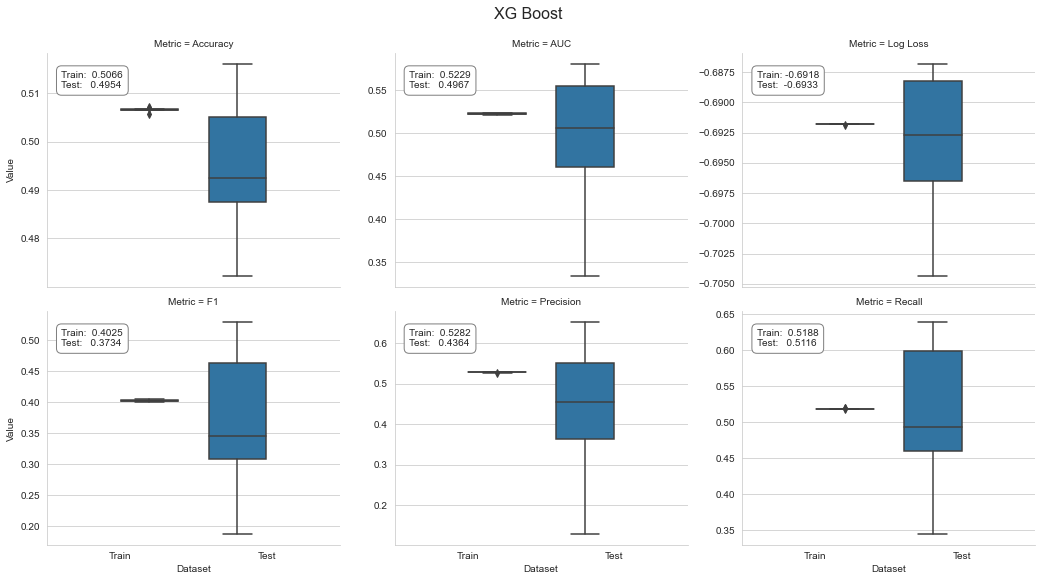

In [351]:
plot_result(xbg_result, model='XG Boost')#, fname=f'figures/{algo}_cv_result')

### Feature Importance

In [352]:
xgb_clf.fit(X=X, y=y)

[16:39:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:39:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=True,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [353]:
fi = pd.Series(xgb_clf.feature_importances_, 
               index=X.columns)

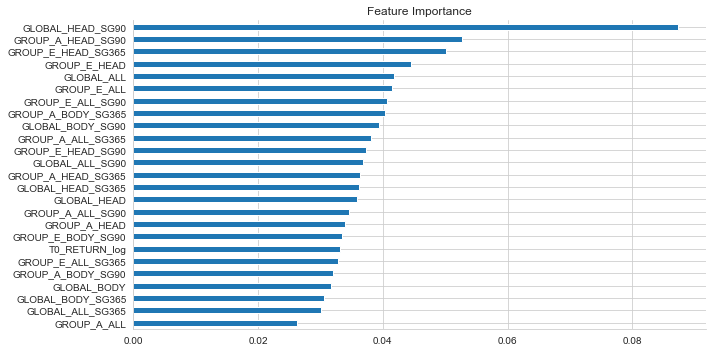

In [354]:
fi.nlargest(25).sort_values().plot.barh(figsize=(10, 5), 
                                        title='Feature Importance')
sns.despine()
plt.tight_layout();